In [44]:
# if running without local install
import sys, os
sys.path.append(os.path.abspath("..\\.."))

import GeoDataKit.geoplot as gp

import numpy as np
import pandas as pd
import geopandas as gpd

## Loading dataset
The dataset contains volcanic output locations from the eastern Velay, France.

Rocktype gives the type of rock of the volcanic output (felsic or mafic), points flagged as others correspond to intermediate rocktypes or maars.

In [16]:
data = pd.read_csv ("Pereira_etal_Velay.csv")

In [47]:
# reprojection
data.rename(columns={"x":"long","y":"lat"}, inplace= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 0 to 504
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   long      505 non-null    float64
 1   lat       505 non-null    float64
 2   RockType  505 non-null    object 
dtypes: float64(2), object(1)
memory usage: 15.8+ KB


In [49]:
gdata = gpd.GeoDataFrame(
    data,
    geometry = gpd.points_from_xy(data.long, data.lat),
    crs= "EPSG:4326" # WGS84
).to_crs("EPSG:2154")
gdata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   long      505 non-null    float64 
 1   lat       505 non-null    float64 
 2   RockType  505 non-null    object  
 3   geometry  505 non-null    geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 19.7+ KB


In [52]:
gdata.explore(column= "RockType")

In [54]:
gdata.get_coordinates().to_numpy().T

array([[ 775621.78440361, 6453819.36037775],
       [ 775695.33241142, 6453180.28272107],
       [ 775812.5517115 , 6453096.19180161],
       ...,
       [ 792606.53331547, 6421462.93406905],
       [ 792720.71429542, 6421489.9576882 ],
       [ 792730.12889313, 6421287.04176584]])

## Hough Study

### All points

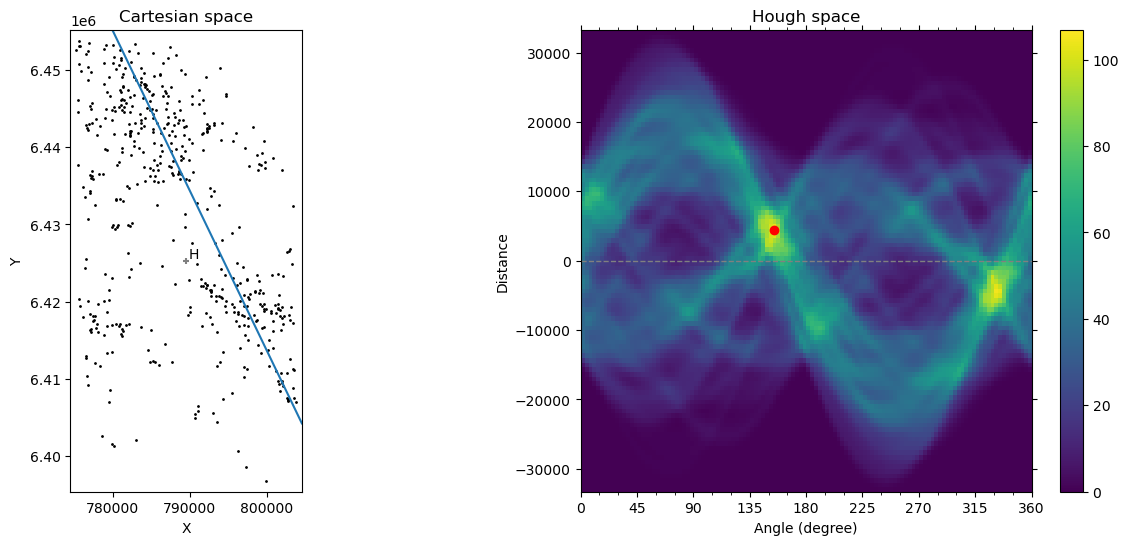

In [60]:
velay_data = gdata.get_coordinates().to_numpy().T
hgt = gp.HoughTransform(velay_data, update_area=True)
#hgt.select_data_point(2)
hgt.hough.update_accumulator(kernel_type="gaussian",sigma=1000)
hgp = gp.HoughPlot(hgt)
hgp.plot(show_selected=True)

### Felsic outputs

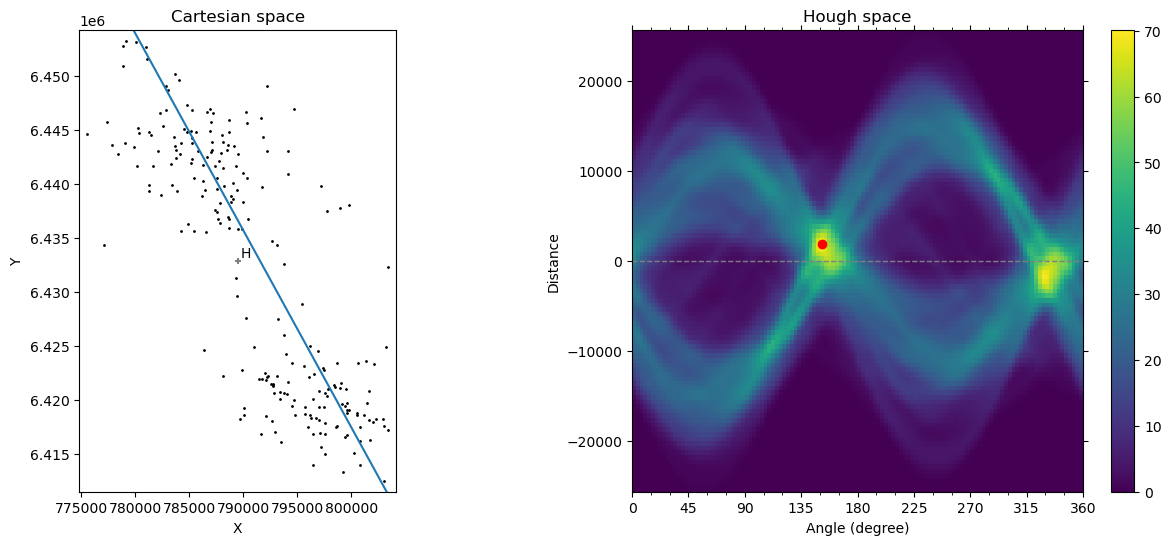

In [62]:
felsic_data = gdata.loc[data["RockType"]=="Felsic"].get_coordinates().to_numpy().T
hgt = gp.HoughTransform(felsic_data, update_area=True)
#hgt.select_data_point(2)
hgt.hough.update_accumulator(kernel_type="gaussian",sigma=1000)
hgp = gp.HoughPlot(hgt)
hgp.plot(show_selected=False,
         show_circle=True,show_hough_point=True,show_triangle=True,
                      show_vector=True)

### Mafic outputs

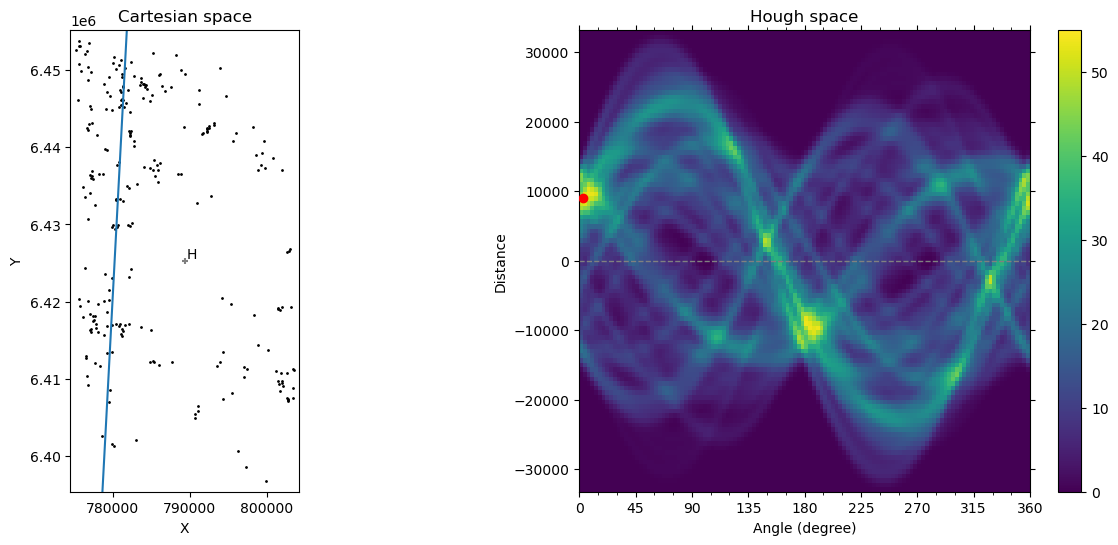

In [65]:
mafic_data = gdata.loc[data["RockType"]=="Mafic"].get_coordinates().to_numpy().T
hgt = gp.HoughTransform(mafic_data, update_area=True)
#hgt.select_data_point(2)
hgt.hough.update_accumulator(kernel_type="gaussian",sigma=1000)
hgp = gp.HoughPlot(hgt)
hgp.plot(show_selected=False,
         show_circle=True,show_hough_point=True,show_triangle=True,
                      show_vector=True)

## Interactive map

In [67]:
import ipywidgets as widgets
hgt = gp.HoughTransform(velay_data,update_area=True)
@widgets.interact(
    hgt=widgets.fixed(hgt),
    selected_index = widgets.IntSlider(value=0,min=0,max=n,step=1,continuous_update=False),
    selected_azimuth = widgets.IntSlider(value=45,min=0,max=360,step=1,continuous_update=False),
    azimuth = widgets.IntSlider(value=45,min=0,max=360,step=1,continuous_update=False),
    dist = widgets.FloatSlider(value=0,min=-hgt.hough.distance_max,max=hgt.hough.distance_max,step=0.1,continuous_update=False),
    sigma = widgets.FloatSlider(value=300,min=100,max=3000,step=100,continuous_update=False),
    kernel = gp.kernel_dict.keys(),
    show_construction = [False,True]
)
def interact_hough(hgt,selected_index,selected_azimuth,azimuth,dist,sigma,kernel,show_construction):
    hgp = gp.HoughPlot(hgt)
    hgt.hough.update_accumulator(kernel_type=kernel,sigma=sigma)
    hgp.plot(show_selected=True,index=selected_index,az=selected_azimuth,
            show_circle=show_construction, show_triangle=show_construction,
            show_hough_point=show_construction, show_vector=show_construction)
    hgp.plot_manual(azimuth,dist)

interactive(children=(IntSlider(value=0, continuous_update=False, description='selected_index', max=12), IntSl…

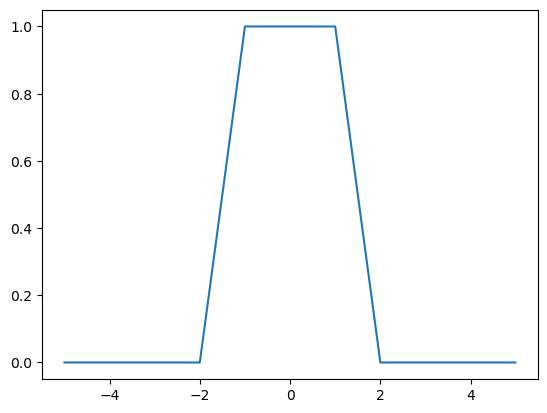

In [9]:
kernel = gp.HoughKernel.kernel(type="line",width=2)
delta = np.arange(-5,5,0.01)
gp.plt.plot(delta,kernel(delta))

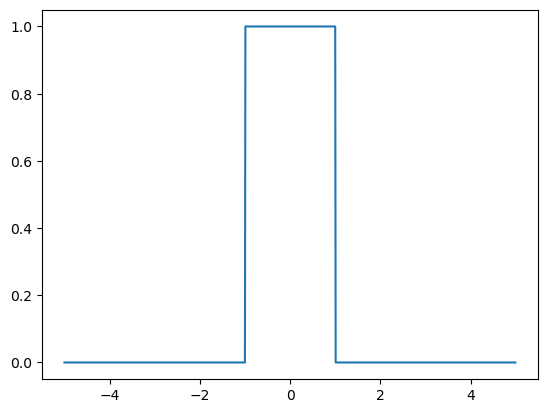

In [10]:
kernel = HoughKernel.kernel(type="line",width=2,antialiase=False)
delta = np.arange(-5,5,0.01)
plt.plot(delta,kernel(delta))

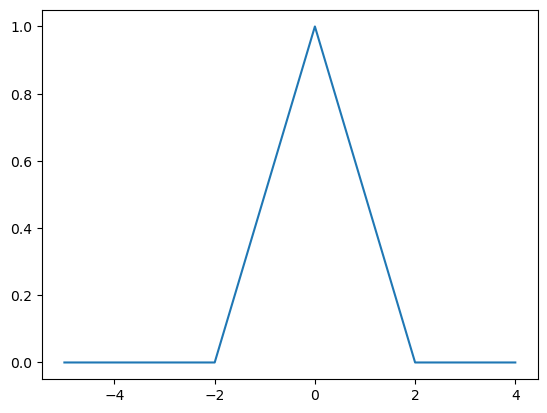

In [11]:
kernel = HoughKernel.kernel(type="triangle",sigma=2)
delta = np.arange(-5,5)
plt.plot(delta,kernel(delta))

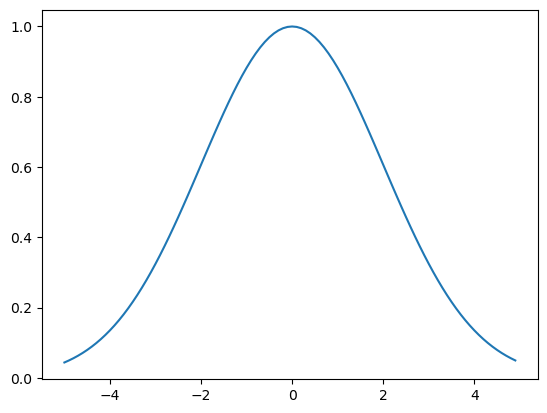

In [12]:
kernel = HoughKernel.kernel(type="gaussian",sigma=2)
delta = np.arange(-5,5,0.1)
plt.plot(delta,kernel(delta))